In [1]:
import cv2
import numpy as np

In [3]:
MAX_FEATURES = 10000
GOOD_MATCH_PERCENT = 0.15

In [4]:
def alignImages(im1, im2):

  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)

  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)

  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]

  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  cv2.imwrite("matches.jpg", imMatches)

  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))

  return im1Reg, h

In [15]:
refFilename = "omnimatte/datasets/tennis/rgb/0001.png"
print("Reading reference image: ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
imFilename = "omnimatte/datasets/tennis/rgb/0030.png"
print("Reading image to align: ", imFilename);
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

print("Aligning images ...")
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, h = alignImages(im, imReference)

# Print estimated homography
print("Estimated homography : \n",  h)

Reading reference image:  omnimatte/datasets/tennis/rgb/0001.png
Reading image to align:  omnimatte/datasets/tennis/rgb/0030.png
Aligning images ...
Estimated homography : 
 [[ 1.37761248e+00  1.52052576e-01 -4.24559470e+02]
 [ 5.60362261e-02  1.38874640e+00 -1.32409501e+01]
 [ 7.42706961e-04  9.98848300e-04  1.00000000e+00]]


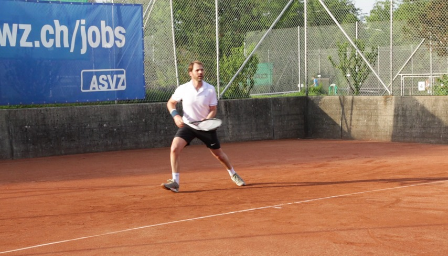

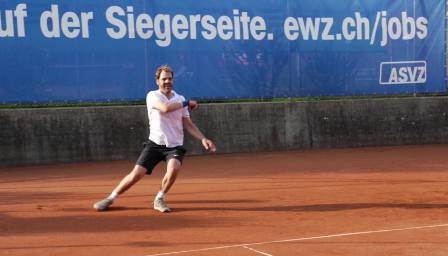

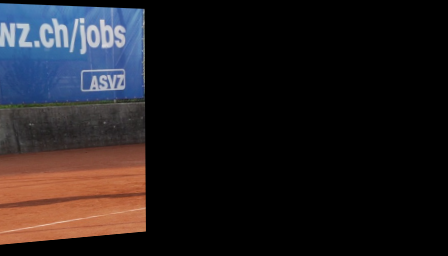

In [16]:
from PIL import Image
from IPython.display import display
imges = [imReference, im, imReg]
for fin_img in imges:
    img_rgb = cv2.cvtColor(fin_img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))

In [5]:
from pathlib import Path

In [17]:
src_dir = "RealBasicVSR/data/demo_000/"
src_p = Path(src_dir)

In [18]:
img_ps = list(src_p.glob("*.png"))

In [19]:
img_ps.sort()

In [21]:
ref_p = img_ps[0]
ref_img = cv2.imread(str(ref_p), cv2.IMREAD_COLOR)

In [22]:
homographies = []
homographies.append(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]))
for img_p in img_ps[1:]:
    cur_img = cv2.imread(str(img_p), cv2.IMREAD_COLOR)
    _, h = alignImages(ref_img, cur_img)
    homographies.append(h.reshape(-1))

In [23]:
homographies_np = np.vstack(homographies)

In [24]:
homographies_np[0]

array([1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [25]:
np.savetxt("omnimatte/test_homographies_traffic.txt",homographies_np, fmt="%f")